<font size = "5"> **Chapter 1: [Introduction](Lab_00-Introduction.ipynb)** </font>


<hr style="height:1px;border-top:4px solid #FF8200" />

# Analysis of the Images of Lab 1


[Download](https://raw.githubusercontent.com/gduscher/MSE672-Introduction-to-TEM//main/Lab_Course/Lab_00-Introduction.ipynb)
 
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/gduscher/MSE672-Introduction-to-TEM/blob/main/Lab_Course/Lab_00-Introduction.ipynb)
    

part of 

<font size = "5"> **[MSE672:  Introduction to Transmission Electron Microscopy](../_MSE672_Intro_TEM.ipynb)**</font>


by Gerd Duscher, Spring 2021

Microscopy Facilities<br>
Joint Institute of Advanced Materials<br>
Materials Science & Engineering<br>
The University of Tennessee, Knoxville

Background and methods to analysis and quantification of data acquired with transmission electron microscopes.

## Introduction

The practical Lab has two major parts:
- Basic alignment of TEM
- Acquisition of images

The Homework has three parts:
- Image Magnification
- Image Rotation
- Magnificaiton of Objective Lens

First we need to learn how to open a file (in Gatan's *Digital Micrograph* format with extension ``.dm3``

Then we will calibrate the image magnification

and finally determine the rotation.

The magnification of the objective lens is left to be your problem.



## Load relevant python packages
### Check Installed Packages

In [1]:
import sys
from pkg_resources import get_distribution, DistributionNotFound

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = get_distribution(package_name).version
    except (DistributionNotFound, ImportError) as err:
        version = '-1'
    return version

# Colab setup ------------------
if 'google.colab' in sys.modules:
    !pip install pyTEMlib -q
# pyTEMlib setup ------------------
else:
    if test_package('pyTEMlib') < '0.2021.2.5':
        print('installing pyTEMlib')
        !{sys.executable} -m pip install  --upgrade pyTEMlib -q
# ------------------------------
print('done')

done


## Import numerical and plotting python packages
Import the python packages that we will use:

Beside the basic numerical (numpy) and plotting (pylab of matplotlib) libraries,

and some libraries from the book
* file_tools library

In [3]:
# import matplotlib and numpy
#                       use "inline" instead of "notebook" for non-interactive
#                       use widget for jupyterlab needs ipympl to be installed
import sys
if 'google.colab' in sys.modules:
    %pylab --no-import-allv notebook
else:       
    %pylab --no-import-all widget
    %gui qt

# Import libraries from pyTEMlib
import pyTEMlib
import pyTEMlib.file_tools as ft     # File input/ output library
import pyTEMlib.image_tools as it

# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ',pyTEMlib.__version__)

__notebook__ = '2_Image_Registration'
__notebook_version__ = '2021_01_09'

Populating the interactive namespace from numpy and matplotlib
0.2021.02.09


## Open an Image
Please, load an image. 

You select here (with the ``use_file_widget`` parameter), whether an **open file dialog** apears in the code cell below the next one or whether you want to get a list of files (Nion has a weird way of dealing with file names).

In [6]:
## # ------ Input ------- #
use_file_widget = False
load_example = False
# -------------------- #

if load_example:
    drive_directory = '.'
else:
    drive_directory = ft.get_last_path()

bokeh_plot = False
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount("/content/drive")
    if load_example:
        drive_directory = '/content/example-data'
    else:
        drive_directory = 'drive/MyDrive/'
    bokeh_plot = True

# Open file widget and select file which will be opened in code cell below
if use_file_widget:
    file_widget = ft.FileWidget(drive_directory)
else: 
    print('File dialog will be activated in next cell')

File dialog will be activated in next cell


### Plot Image 
Either we load the selected file in the widget above above or a file dialog window appears.

This is the point the notebook can be repeated with a new file. Either select a file above again (without running the code cell above) or open a file dialog here

Note that the **open file dialog** might not apear in the foreground!

C:\Users\gduscher\Anaconda3\lib\site-packages\pyNSID\io\hdf_utils.py:351: FutureWarning: validate_h5_dimension may be removed in a future version
  warn('validate_h5_dimension may be removed in a future version',
C:\Users\gduscher\Anaconda3\lib\site-packages\pyNSID\io\nsi_reader.py:41: FutureWarning: This Reader will eventually be moved to the ScopeReaders package. Be prepared to change your import statements
  warn('This Reader will eventually be moved to the ScopeReaders package'


Available Datasets
GOLD_NP_DIFF


<IPython.core.display.Javascript object>


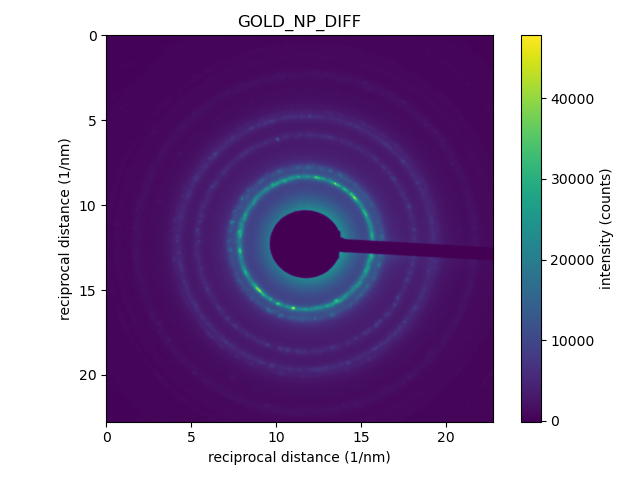

In [8]:
try: 
    main_dataset.h5_dataset.file.close()
except:
    pass

if use_file_widget:
    main_dataset = ft.open_file(str(file_widget.file_name))
else:
    main_dataset = ft.open_file()
current_channel = main_dataset.h5_dataset.parent.parent

if main_dataset.data_type.name != 'IMAGE':
    print(f"Please load an image for this notebook, this is an {main_dataset.data_type}")
    
dataset_choice = ft.ChooseDataset(current_channel, show_dialog=False)                                          
print('Available Datasets')
for dset  in dataset_choice.dataset_list:
    print(dset.title.split('/')[-1])
    
main_dataset.plot()  # note this needs a view reference for interaction

## Magnification Calibration
In the age of computer images we better speak of Image scale calbration.

We need to know how wide and high is a single pixel in the image.

Here we assume a spuare pixel and only one dimesnion is necessary

In the pixel below click on the beginning and the end of a feature of known size.


<IPython.core.display.Javascript object>


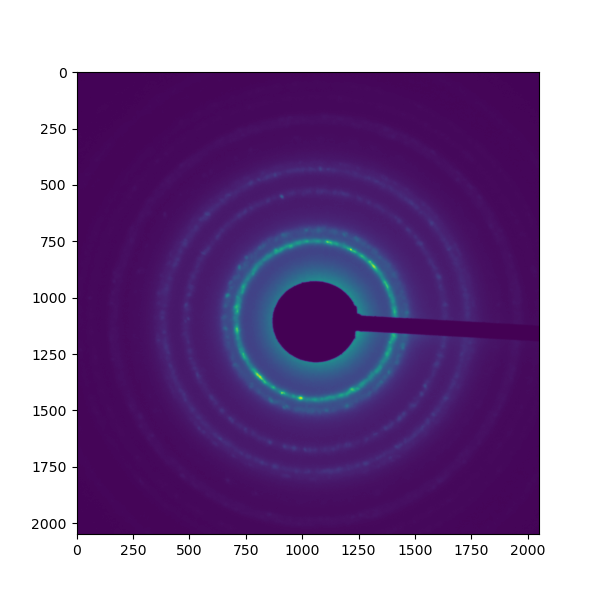

In [78]:
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(main_dataset.T,  origin='upper')
start_point = [-1,-1]
end_point = [-1,-1]

def onclick(event):
    global start_point, end_point

    if start_point[0]<0:
        end_point = [event.xdata, event.ydata]
    else:
        end_point = start_point.copy()
    start_point = [event.xdata, event.ydata]
        
    ax.clear()
    ax.imshow(main_dataset.T)
    #plt.scatter(atoms[:,0], atoms[:,1])
    plt.scatter(start_point[0], start_point[1], color='orange')
    plt.scatter(end_point[0], end_point[1], color='blue')
    plt.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], color='blue')
    plt.text(start_point[0], start_point[1], f'{np.linalg.norm(np.array(start_point)-np.array(end_point)):.1f} pixel', 
             bbox=dict(facecolor='red', alpha=0.5),
             verticalalignment='bottom')
    
cid = fig.canvas.mpl_connect('button_press_event', onclick)


After you selected a feature, you now can calculate the size of a pixel. 
The plotting routine needs the ``field of view`` (FOV) which is set by the *extent* - parameter.

The image scale is 0.01545 nm per pixel


<IPython.core.display.Javascript object>


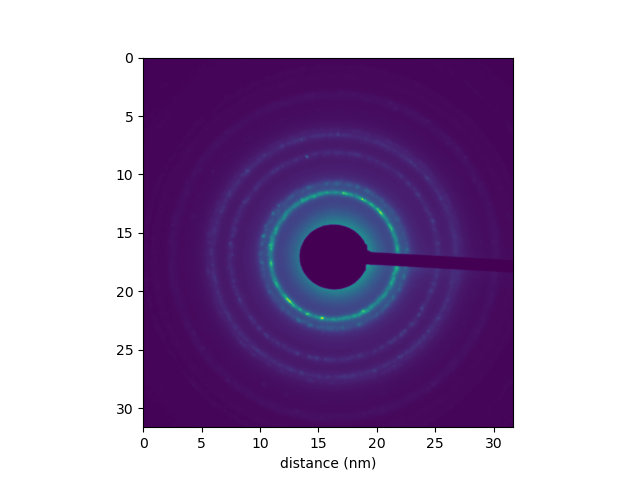

Text(0.5, 0, 'distance (nm)')

In [95]:
length_of_feature = 10 #(in nm)
length_of_selection = np.linalg.norm(np.array(start_point)-np.array(end_point))
pixel_size = length_of_feature/length_of_selection
print(f'The image scale is {pixel_size:.5f} nm per pixel')

extent=[0,main_dataset.shape[0]*pixel_size, main_dataset.shape[1]*pixel_size,0]
plt.figure()
plt.imshow(main_dataset.T, extent=extent)
plt.xlabel('distance (nm)')

## Rotation Calibration

For the rotation calibration we do more or less the same thing but now we determine the angle of the feature with respect to the x-axis.

For that we use the ``arctan2`` (arcus tangens) function of numpy.

Please note that numpy operates on radians and we have to convert these angles with the ``degrees`` of numpy.

<IPython.core.display.Javascript object>


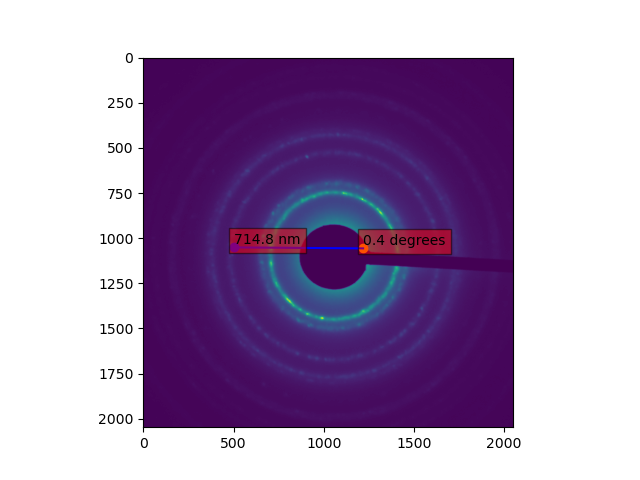

In [114]:
extent=[0,main_dataset.shape[0]*pixel_size, main_dataset.shape[1]*pixel_size,0]
fig = plt.figure()
plt.imshow(main_dataset.T, extent=extent)
plt.xlabel('distance (nm)')


start_point = [-1,-1]
end_point = [-1,-1]

def onclick(event):
    global start_point, end_point

    if start_point[0]<0:
        end_point = [event.xdata, event.ydata]
    else:
        end_point = start_point.copy()
    start_point = [event.xdata, event.ydata]
        
    plt.gca().clear()
    plt.gca().imshow(main_dataset.T)
    #plt.scatter(atoms[:,0], atoms[:,1])
    plt.scatter(start_point[0], start_point[1], color='orange')
    plt.scatter(end_point[0], end_point[1], color='blue')
    plt.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], color='blue')
    plt.text(end_point[0], end_point[1], f'{np.linalg.norm(np.array(start_point)-np.array(end_point)):.1f} nm', 
             bbox=dict(facecolor='red', alpha=0.5),
             verticalalignment='bottom')
    plt.text(start_point[0], start_point[1], f'{np.degrees(np.arctan2(start_point[1]- end_point[1], start_point[0]-end_point[0]))%180:.1f} degrees', 
             bbox=dict(facecolor='red', alpha=0.5),
             verticalalignment='bottom')
cid = fig.canvas.mpl_connect('button_press_event', onclick)

Print the angle of the feature along a line

In [113]:
angle = np.degrees(np.arctan2(start_point[1]- end_point[1], start_point[0]-end_point[0]))%180
    
print(f'Selected feature in {main_dataset.title} has angle of {angle:.1f} degrees')

print('Image Name,    Angle (degree)')
print(f'{main_dataset.title},  {angle:.1f}')

Selected feature in GOLD_NP_DIFF has angle of 91.1 degrees
Image Name,    Angle (dgegree)
GOLD_NP_DIFF,  91.1


## Calibration Curves
For a calibration we need to compare the pixel_size and angle parameters of at least two different images.

Plot the magnification value over the pixel_size and angle.
